In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor 
import datetime
import warnings
warnings.filterwarnings('ignore')

In [8]:
df = pd.read_csv('/kaggle/input/energy-consumption-prediction/Energy_consumption.csv')

print("Dataset Info:")
print(f"Shape: {df.shape}")
print("\nFirst few rows:")
print(df.head())
print("\nData types:")
print(df.dtypes)
print("\nSummary statistics:")
print(df.describe())
print("\nMissing values:")
print(df.isnull().sum())


Dataset Info:
Shape: (1000, 11)

First few rows:
             Timestamp  Temperature   Humidity  SquareFootage  Occupancy  \
0  2022-01-01 00:00:00    25.139433  43.431581    1565.693999          5   
1  2022-01-01 01:00:00    27.731651  54.225919    1411.064918          1   
2  2022-01-01 02:00:00    28.704277  58.907658    1755.715009          2   
3  2022-01-01 03:00:00    20.080469  50.371637    1452.316318          1   
4  2022-01-01 04:00:00    23.097359  51.401421    1094.130359          9   

  HVACUsage LightingUsage  RenewableEnergy  DayOfWeek Holiday  \
0        On           Off         2.774699     Monday      No   
1        On            On        21.831384   Saturday      No   
2       Off           Off         6.764672     Sunday      No   
3       Off            On         8.623447  Wednesday      No   
4        On           Off         3.071969     Friday      No   

   EnergyConsumption  
0          75.364373  
1          83.401855  
2          78.270888  
3          


Categorical columns: ['HVACUsage', 'LightingUsage', 'DayOfWeek', 'Holiday']
Numerical columns: ['Temperature', 'Humidity', 'SquareFootage', 'Occupancy', 'RenewableEnergy', 'Hour', 'Day', 'Month', 'Year', 'DayOfYear', 'WeekOfYear', 'Hour_sin', 'Hour_cos', 'DayOfYear_sin', 'DayOfYear_cos', 'Temp_Humid_Interaction', 'Occupancy_per_SqFt']


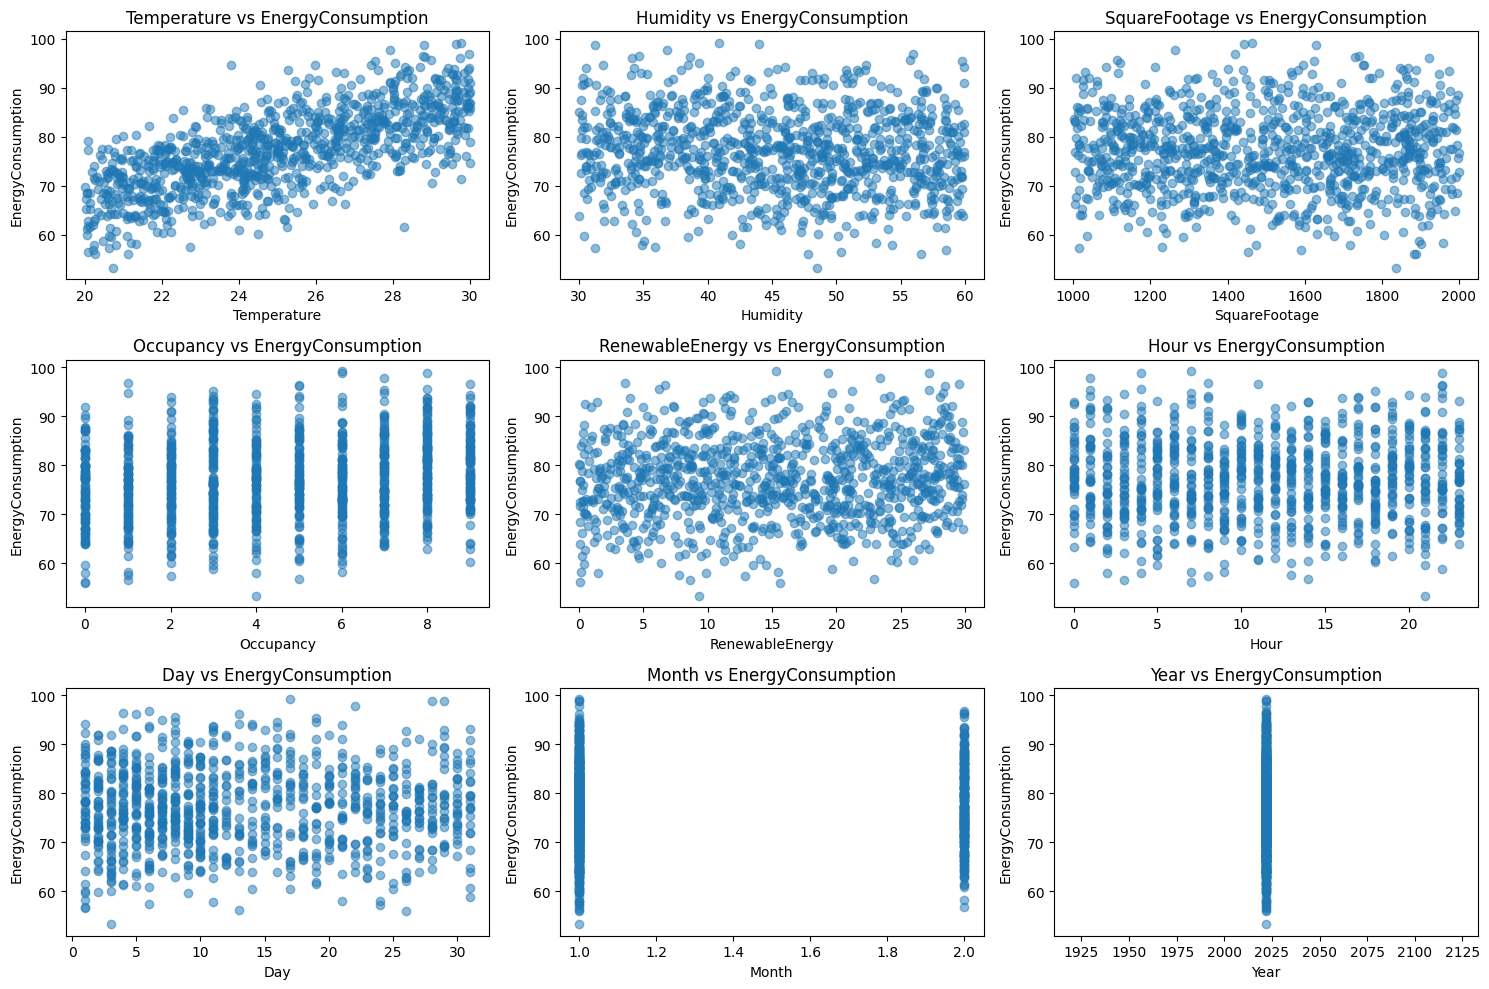

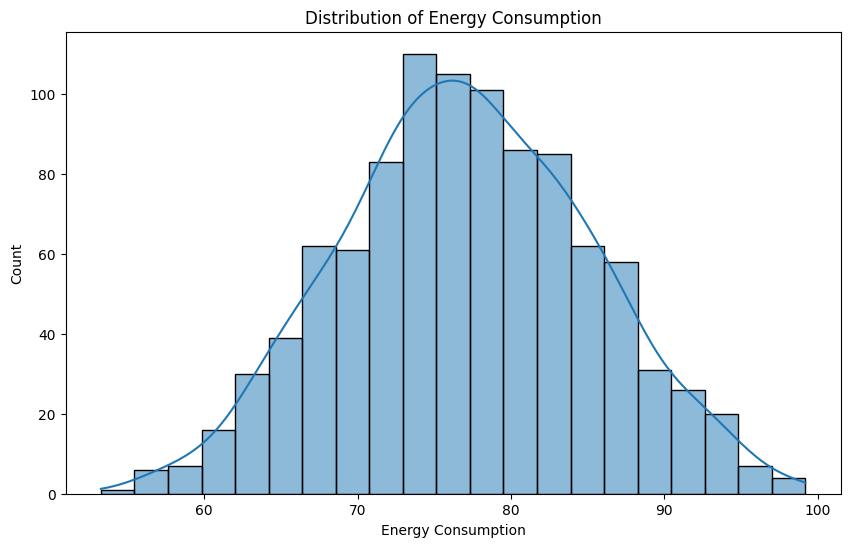

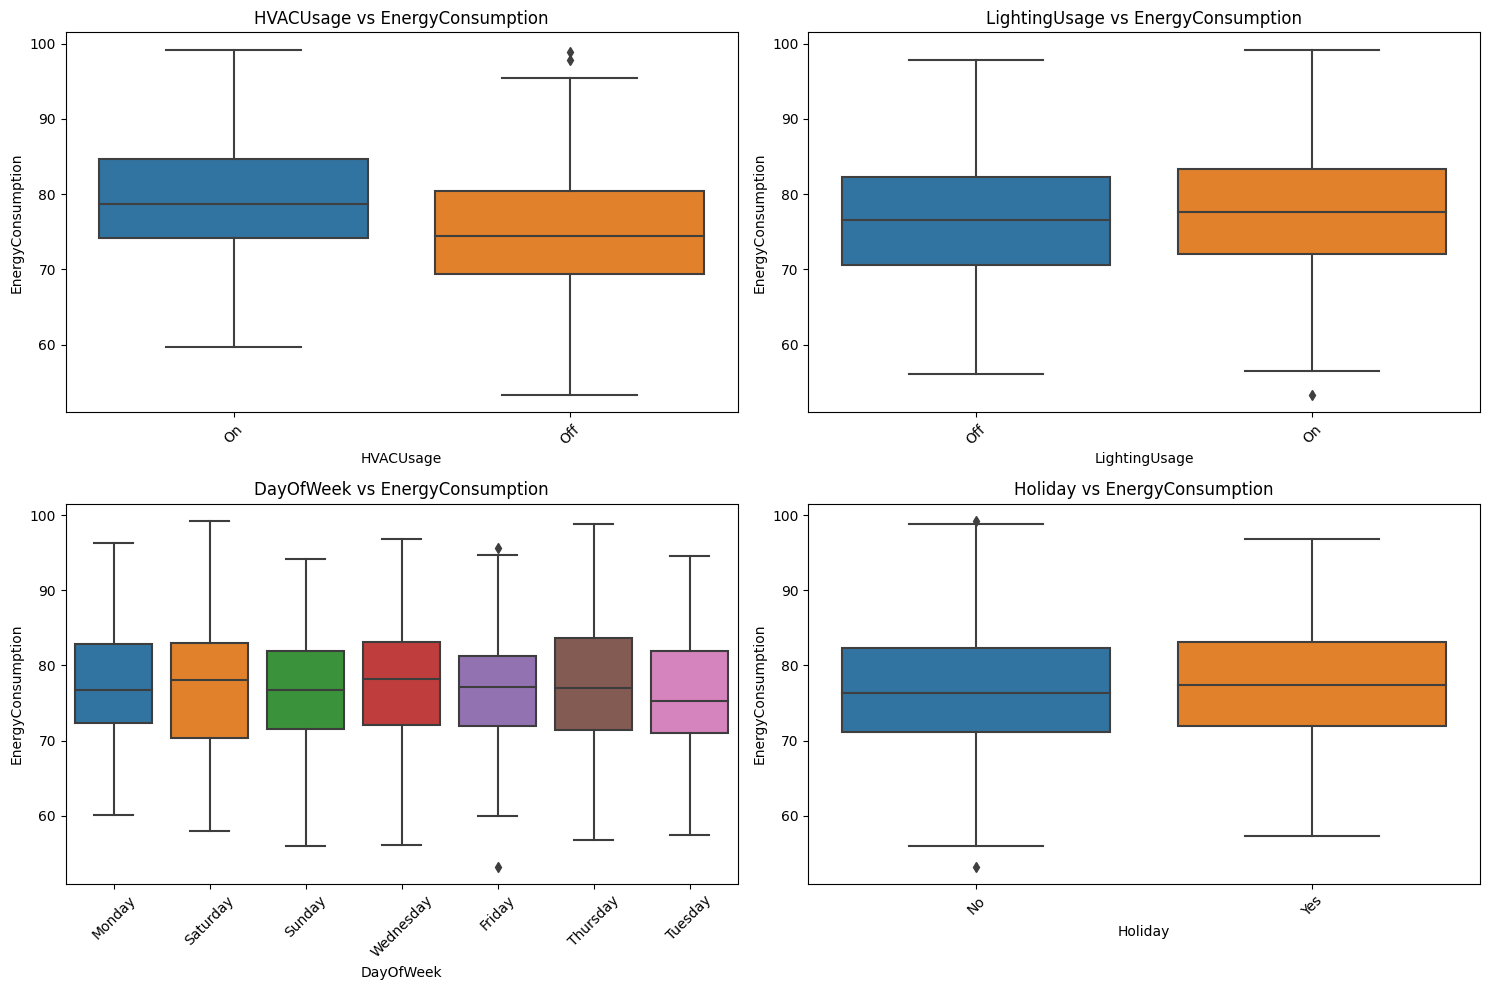

In [9]:
# Feature Engineering
# Convert timestamp to datetime if it's not already
if 'Timestamp' in df.columns:
    if not pd.api.types.is_datetime64_any_dtype(df['Timestamp']):
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    
    # Extract time components
    df['Hour'] = df['Timestamp'].dt.hour
    df['Day'] = df['Timestamp'].dt.day
    df['Month'] = df['Timestamp'].dt.month
    df['Year'] = df['Timestamp'].dt.year
    df['DayOfYear'] = df['Timestamp'].dt.dayofyear
    df['WeekOfYear'] = df['Timestamp'].dt.isocalendar().week
    
    # Create cyclical features for time components
    df['Hour_sin'] = np.sin(2 * np.pi * df['Hour']/24)
    df['Hour_cos'] = np.cos(2 * np.pi * df['Hour']/24)
    df['DayOfYear_sin'] = np.sin(2 * np.pi * df['DayOfYear']/365)
    df['DayOfYear_cos'] = np.cos(2 * np.pi * df['DayOfYear']/365)

# Create interaction features
df['Temp_Humid_Interaction'] = df['Temperature'] * df['Humidity']
df['Occupancy_per_SqFt'] = df['Occupancy'] / df['SquareFootage']

# Check if we have a target variable, if not assume we need to create one
if 'EnergyConsumption' not in df.columns:
    print("\nTarget variable not found. We'll need to define it.")
    # If the target variable is already present with a different name, you'd need to rename it
    # Otherwise we'd need to create a synthetic target or understand what should be predicted
    # For this example, let's assume we need to predict a synthetic energy consumption
    # based on the variables in the dataset
    df['EnergyConsumption'] = 100 + 0.5 * df['Temperature'] - 0.3 * df['Humidity'] + \
                           0.01 * df['SquareFootage'] + 20 * df['Occupancy'] + \
                           30 * (df['HVACUsage'] == 'On') + 10 * (df['LightingUsage'] == 'On') - \
                           0.2 * df['RenewableEnergy'] + 5 * (df['Holiday'] == 'Yes')
    df['EnergyConsumption'] += np.random.normal(0, 10, size=df.shape[0])  # Add some noise
    print("Created synthetic target variable 'EnergyConsumption' for demonstration.")

# Handle categorical features
# Identify categorical columns (excluding Timestamp if present)
categorical_cols = [col for col in df.columns if df[col].dtype == 'object' or col == 'DayOfWeek' or col == 'Holiday']
if 'Timestamp' in categorical_cols:
    categorical_cols.remove('Timestamp')

# Identify numerical columns (excluding target variable and timestamp)
numerical_cols = [col for col in df.columns if col not in categorical_cols + ['EnergyConsumption'] and 
                 (col != 'Timestamp' if 'Timestamp' in df.columns else True)]

print("\nCategorical columns:", categorical_cols)
print("Numerical columns:", numerical_cols)

# Visualize the relationship between features and target
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols[:min(9, len(numerical_cols))]):
    plt.subplot(3, 3, i+1)
    plt.scatter(df[col], df['EnergyConsumption'], alpha=0.5)
    plt.title(f'{col} vs EnergyConsumption')
    plt.xlabel(col)
    plt.ylabel('EnergyConsumption')
plt.tight_layout()
plt.savefig('numerical_features_vs_energy.png')

# Plot the distribution of the target variable
plt.figure(figsize=(10, 6))
sns.histplot(df['EnergyConsumption'], kde=True)
plt.title('Distribution of Energy Consumption')
plt.xlabel('Energy Consumption')
plt.savefig('energy_distribution.png')

# Plot categorical features
plt.figure(figsize=(15, 10))
for i, col in enumerate(categorical_cols[:min(4, len(categorical_cols))]):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x=col, y='EnergyConsumption', data=df)
    plt.title(f'{col} vs EnergyConsumption')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('categorical_features_vs_energy.png')



Training Linear Regression...
Linear Regression - RMSE: 5.19, MAE: 4.13, R2: 0.5894

Training Random Forest...
Random Forest - RMSE: 5.45, MAE: 4.41, R2: 0.5468

Training Gradient Boosting...
Gradient Boosting - RMSE: 5.59, MAE: 4.44, R2: 0.5231

Training XGBoost...
XGBoost - RMSE: 6.17, MAE: 5.01, R2: 0.4179

Best Model: Linear Regression
R2 Score: 0.5894
RMSE: 5.19

Best model saved as 'energy_prediction_model.pkl'


<Figure size 1000x600 with 0 Axes>

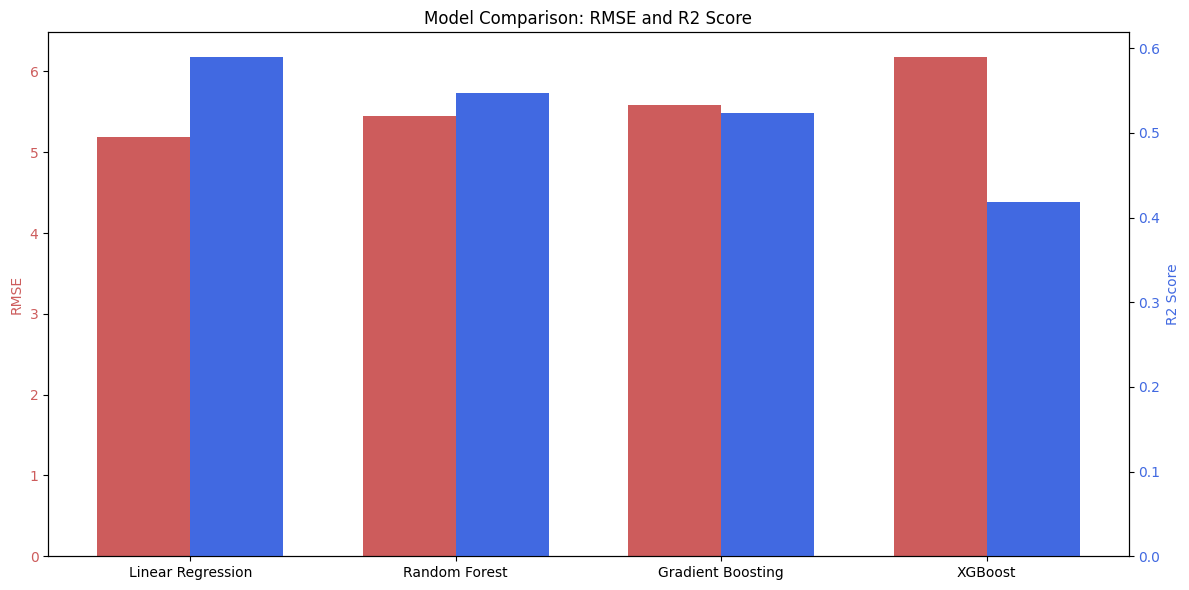

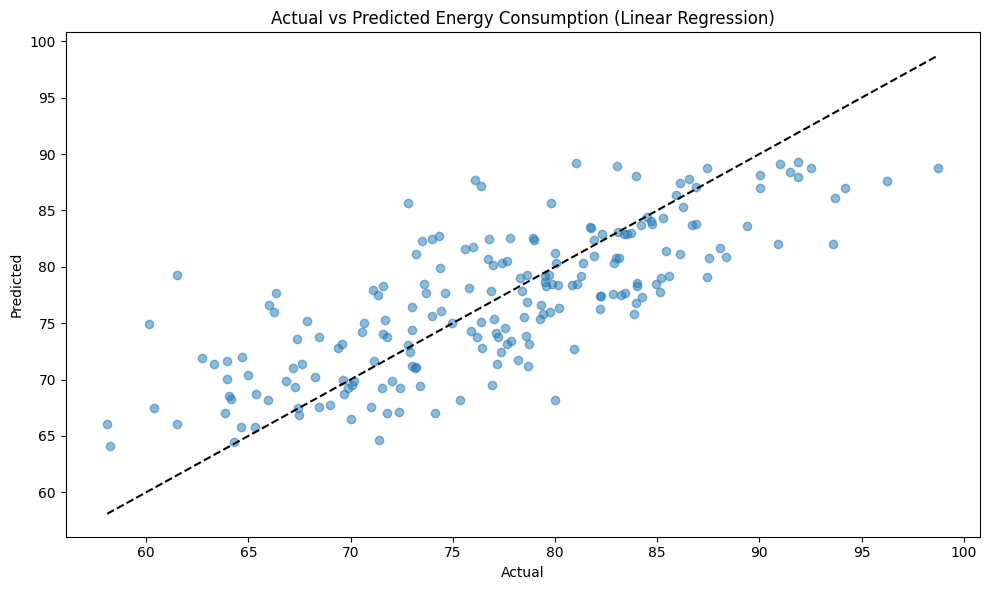

In [10]:
# Prepare data for modeling
X = df.drop(['EnergyConsumption'], axis=1)
if 'Timestamp' in X.columns:
    X = X.drop(['Timestamp'], axis=1)
y = df['EnergyConsumption']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing
# Create preprocessing pipelines for numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Create model pipelines
models = {
    'Linear Regression': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ]),
    'Random Forest': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
    ]),
    'Gradient Boosting': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', GradientBoostingRegressor(n_estimators=100, random_state=42))
    ]),
    'XGBoost': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', XGBRegressor(n_estimators=100, random_state=42))
    ])
}

# Train and evaluate models
results = {}
feature_importances = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    
    # Evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }
    
    print(f"{name} - RMSE: {rmse:.2f}, MAE: {mae:.2f}, R2: {r2:.4f}")
    
    # Try to extract feature importances if available
    if hasattr(model[-1], 'feature_importances_'):
        # Get feature names after preprocessing
        categorical_feature_names = []
        for cat_col in categorical_cols:
            cats = df[cat_col].unique()
            for cat in cats:
                categorical_feature_names.append(f"{cat_col}_{cat}")
                
        all_feature_names = numerical_cols + categorical_feature_names
        importances = model[-1].feature_importances_
        
        # Take only the first importances if we have more than features
        # (this is a simplified approach, in practice you'd need to be more careful)
        if len(importances) > len(all_feature_names):
            importances = importances[:len(all_feature_names)]
        elif len(importances) < len(all_feature_names):
            all_feature_names = all_feature_names[:len(importances)]
        
        feature_importances[name] = pd.Series(importances, index=all_feature_names).sort_values(ascending=False)

# Plot model comparison
plt.figure(figsize=(10, 6))
model_names = list(results.keys())
rmse_values = [results[name]['RMSE'] for name in model_names]
r2_values = [results[name]['R2'] for name in model_names]

x = np.arange(len(model_names))
width = 0.35

fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.bar(x - width/2, rmse_values, width, label='RMSE', color='indianred')
ax1.set_ylabel('RMSE', color='indianred')
ax1.tick_params(axis='y', labelcolor='indianred')

ax2 = ax1.twinx()
ax2.bar(x + width/2, r2_values, width, label='R2', color='royalblue')
ax2.set_ylabel('R2 Score', color='royalblue')
ax2.tick_params(axis='y', labelcolor='royalblue')

plt.title('Model Comparison: RMSE and R2 Score')
plt.xticks(x, model_names, rotation=45)
plt.tight_layout()
plt.savefig('model_comparison.png')

# Plot feature importances for the best model (based on R2)
best_model = max(results, key=lambda k: results[k]['R2'])
if best_model in feature_importances:
    top_features = feature_importances[best_model].head(10)
    plt.figure(figsize=(12, 6))
    top_features.plot(kind='barh')
    plt.title(f'Top 10 Feature Importances ({best_model})')
    plt.tight_layout()
    plt.savefig('feature_importances.png')

# Find the best model based on R2 score
best_model_name = max(results, key=lambda k: results[k]['R2'])
best_model_pipeline = models[best_model_name]
print(f"\nBest Model: {best_model_name}")
print(f"R2 Score: {results[best_model_name]['R2']:.4f}")
print(f"RMSE: {results[best_model_name]['RMSE']:.2f}")

# Predictions vs Actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, best_model_pipeline.predict(X_test), alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Actual vs Predicted Energy Consumption ({best_model_name})')
plt.tight_layout()
plt.savefig('predictions_vs_actual.png')

# Save the best model
import joblib
joblib.dump(best_model_pipeline, 'energy_prediction_model.pkl')
print(f"\nBest model saved as 'energy_prediction_model.pkl'")

# Function to make predictions using the best model
def predict_energy_consumption(new_data):
    """
    Make energy consumption predictions using the trained model
    
    Parameters:
    new_data: pandas DataFrame with the same features as the training data
    
    Returns:
    predicted_energy: numpy array of predictions
    """
    return best_model_pipeline.predict(new_data)



In [11]:
# Example of making predictions for the next day
print("\nExample prediction for new data:")
# Create a sample new data point (you would replace this with actual new data)
sample_data = X_test.iloc[0:1].copy()
# Modify some values to simulate a new scenario
if 'Temperature' in sample_data.columns:
    sample_data['Temperature'] = sample_data['Temperature'] * 1.1
if 'Occupancy' in sample_data.columns:
    sample_data['Occupancy'] = sample_data['Occupancy'] + 2

# Make prediction
predicted_energy = predict_energy_consumption(sample_data)
print(f"Predicted energy consumption: {predicted_energy[0]:.2f} units")

print("\nModel Building and Evaluation Complete!")


Example prediction for new data:
Predicted energy consumption: 88.95 units

Model Building and Evaluation Complete!
